In [177]:
import tensorflow as tf
from sklearn.metrics import confusion_matrix
from tensorflow.examples.tutorials.mnist import input_data
import matplotlib.pyplot as plt
%matplotlib inline

In [167]:
from sklearn import datasets
from sklearn.svm import SVC
from scipy import misc
import numpy as np
import pandas as pd
from sklearn.tree import DecisionTreeClassifier

In [178]:
mnist = input_data.read_data_sets('./', one_hot=True)
mnist.test.cls = np.argmax(mnist.test.labels, axis=1)

Extracting ./train-images-idx3-ubyte.gz
Extracting ./train-labels-idx1-ubyte.gz
Extracting ./t10k-images-idx3-ubyte.gz
Extracting ./t10k-labels-idx1-ubyte.gz


In [179]:
# We know that MNIST images are 28 pixels in each dimension.
img_size = 28

# Images are stored in one-dimensional arrays of this length.
img_size_flat = img_size * img_size

# Tuple with height and width of images used to reshape arrays.
img_shape = (img_size, img_size)

# Number of classes, one class for each of 10 digits.
num_classes = 10

In [180]:
def plot_images(images, cls_true, cls_pred=None):
    assert len(images) == len(cls_true) == 9
    
    # Create figure with 3x3 sub-plots.
    fig, axes = plt.subplots(3, 3)
    fig.subplots_adjust(hspace=0.3, wspace=0.3)

    for i, ax in enumerate(axes.flat):
        # Plot image.
        ax.imshow(images[i].reshape(img_shape), cmap='binary')

        # Show true and predicted classes.
        if cls_pred is None:
            xlabel = "True: {0}".format(cls_true[i])
        else:
            xlabel = "True: {0}, Pred: {1}".format(cls_true[i], cls_pred[i])

        ax.set_xlabel(xlabel)
        
        # Remove ticks from the plot.
        ax.set_xticks([])
        ax.set_yticks([])
        
    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.
    plt.show()

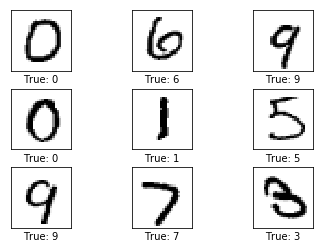

In [181]:
# Get the first images from the test-set.
images = mnist.test.images[10:19]

# Get the true classes for those images.
cls_true = mnist.test.cls[10:19]

# Plot the images and labels using our helper-function above.
plot_images(images=images, cls_true=cls_true)
x,y = mnist.train.next_batch(20)

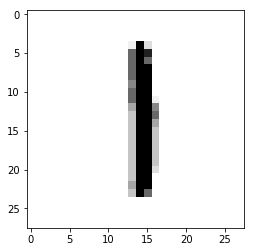

In [182]:
plt.imshow(x[6].reshape((28,28)),cmap='Greys')
plt.show()

## Starting with the simple linear model

In [184]:
x = tf.placeholder(tf.float32, [None, img_size_flat])
y_true = tf.placeholder(tf.float32, [None, num_classes])
y_true_cls = tf.placeholder(tf.int64, [None])
weights = tf.Variable(tf.zeros([img_size_flat, num_classes]))
biases = tf.Variable(tf.zeros([num_classes]))

logits = tf.matmul(x, weights) + biases
y_pred = tf.nn.softmax(logits)
y_pred_cls = tf.argmax(y_pred, axis=1)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits=logits,labels=y_true)
cost = tf.reduce_mean(cross_entropy)
optimizer = tf.train.GradientDescentOptimizer(learning_rate=0.5).minimize(cost)
correct_prediction = tf.equal(y_pred_cls, y_true_cls)
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))



In [185]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())
batch_size = 100

In [206]:
feed_dict_test = {x: mnist.test.images,
                  y_true: mnist.test.labels,
                  y_true_cls: mnist.test.cls}

def print_confusion_matrix():
    # Get the true classifications for the test-set.
    cls_true = mnist.test.cls
    
    # Get the predicted classifications for the test-set.
    cls_pred = sess.run(y_pred_cls, feed_dict=feed_dict_test)

    # Get the confusion matrix using sklearn.
    cm = confusion_matrix(y_true=cls_true,
                          y_pred=cls_pred)

    # Print the confusion matrix as text.
    print(cm)

    # Plot the confusion matrix as an image.
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)

    # Make various adjustments to the plot.
    plt.tight_layout()
    plt.colorbar()
    tick_marks = np.arange(num_classes)
    plt.xticks(tick_marks, range(num_classes))
    plt.yticks(tick_marks, range(num_classes))
    plt.xlabel('Predicted')
    plt.ylabel('True')
    
    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.
    plt.show()
    
    

def plot_example_errors():
    # Use TensorFlow to get a list of boolean values
    # whether each test-image has been correctly classified,
    # and a list for the predicted class of each image.
    correct, cls_pred = sess.run([correct_prediction, y_pred_cls],
                                    feed_dict=feed_dict_test)

    # Negate the boolean array.
    incorrect = (correct == False)
    
    # Get the images from the test-set that have been
    # incorrectly classified.
    images = mnist.test.images[incorrect]
    
    # Get the predicted classes for those images.
    cls_pred = cls_pred[incorrect]

    # Get the true classes for those images.
    cls_true = mnist.test.cls[incorrect]
    
    # Plot the first 9 images.
    plot_images(images=images[0:9],
                cls_true=cls_true[0:9],
                cls_pred=cls_pred[0:9])

def plot_weights():
    # Get the values for the weights from the TensorFlow variable.
    w = sess.run(weights)
    
    # Get the lowest and highest values for the weights.
    # This is used to correct the colour intensity across
    # the images so they can be compared with each other.
    w_min = np.min(w)
    w_max = np.max(w)

    # Create figure with 3x4 sub-plots,
    # where the last 2 sub-plots are unused.
    fig, axes = plt.subplots(3, 4)
    fig.subplots_adjust(hspace=0.3, wspace=0.3)

    for i, ax in enumerate(axes.flat):
        # Only use the weights for the first 10 sub-plots.
        if i<10:
            # Get the weights for the i'th digit and reshape it.
            # Note that w.shape == (img_size_flat, 10)
            image = w[:, i].reshape(img_shape)

            # Set the label for the sub-plot.
            ax.set_xlabel("Weights: {0}".format(i))

            # Plot the image.
            ax.imshow(image, vmin=w_min, vmax=w_max, cmap='seismic')

        # Remove ticks from each sub-plot.
        ax.set_xticks([])
        ax.set_yticks([])
        
    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.
    plt.show()
    

def print_accuracy():
    # Use TensorFlow to compute the accuracy.
    acc = sess.run(accuracy, feed_dict=feed_dict_test)
    
    # Print the accuracy.
    print("Accuracy on test-set: {0:.1%}".format(acc))

def print_confusion_matrix():
    # Get the true classifications for the test-set.
    cls_true = mnist.test.cls
    
    # Get the predicted classifications for the test-set.
    cls_pred = sess.run(y_pred_cls, feed_dict=feed_dict_test)

    # Get the confusion matrix using sklearn.
    cm = confusion_matrix(y_true=cls_true,
                          y_pred=cls_pred)

    # Print the confusion matrix as text.
    print(cm)

    # Plot the confusion matrix as an image.
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues,vmin=0 , vmax=70)
    # plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)

    # Make various adjustments to the plot.
    plt.tight_layout()
    plt.colorbar()
    tick_marks = np.arange(num_classes)
    plt.xticks(tick_marks, range(num_classes))
    plt.yticks(tick_marks, range(num_classes))
    plt.xlabel('Predicted')
    plt.ylabel('True')
    
    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.
    plt.show()

def optimize(num_iterations):
    for i in range(num_iterations):
        # Get a batch of training examples.
        # x_batch now holds a batch of images and
        # y_true_batch are the true labels for those images.
        x_batch, y_true_batch = mnist.train.next_batch(batch_size)
        
        # Put the batch into a dict with the proper names
        # for placeholder variables in the TensorFlow graph.
        # Note that the placeholder for y_true_cls is not set
        # because it is not used during training.
        feed_dict_train = {x: x_batch,
                           y_true: y_true_batch}

        # Run the optimizer using this batch of training data.
        # TensorFlow assigns the variables in feed_dict_train
        # to the placeholder variables and then runs the optimizer.
        sess.run(optimizer, feed_dict=feed_dict_train)

In [193]:
print_accuracy()

Accuracy on test-set: 91.8%


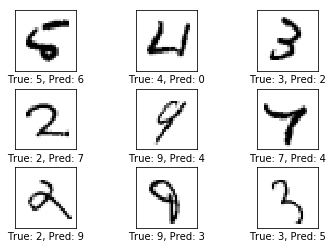

In [194]:
plot_example_errors()

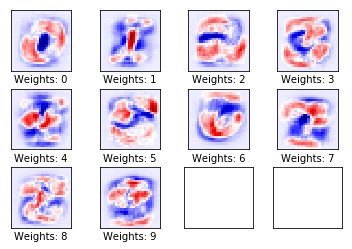

In [200]:
plot_weights()

In [190]:
optimize(num_iterations=1)


In [191]:
# We have already performed 1 iteration.
optimize(num_iterations=9)

In [192]:
# We have already performed 10 iterations.
optimize(num_iterations=990)

[[ 965    0    2    3    0    3    4    1    2    0]
 [   0 1114    2    2    0    2    4    2    9    0]
 [  11   13  903   18    9    2   10   13   42   11]
 [   3    1   16  917    0   30    2   11   18   12]
 [   2    5    3    1  898    0   11    2    6   54]
 [  11    4    3   30    9  778   14    6   29    8]
 [  16    3    5    2    9   13  905    1    4    0]
 [   3    7   21    8    6    1    0  944    2   36]
 [   8   11    7   20    9   31   11   14  844   19]
 [  11    8    2   10   27    6    0   24    7  914]]


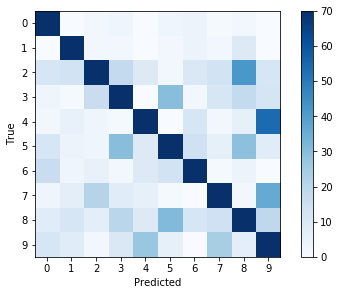

In [207]:
print_confusion_matrix()


## Introducing non-linearity with a hidden layer


In [208]:
# test the model
correct_prediction = tf.equal(tf.argmax(y,1), tf.argmax(y_true,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
print(correct_prediction,accuracy)

Tensor("Equal_25:0", shape=(20,), dtype=bool) Tensor("Mean_47:0", shape=(), dtype=float32)


In [209]:
def fully_connected_activation(input,size_in,size_out):
    # Initialise variables
    W = tf.Variable(tf.truncated_normal([size_in, size_out],stddev=0.1))
    b = tf.Variable(tf.truncated_normal([size_out], stddev=0.1))
    # NN part
    activation = tf.nn.relu(tf.matmul(input,W)+b)
    
    return activation

def fully_connected(input,size_in,size_out):
    # Initialise variables
    W = tf.Variable(tf.truncated_normal([size_in, size_out],stddev=0.1))
    b = tf.Variable(tf.truncated_normal([size_out], stddev=0.1))
    # NN part
    activation = tf.matmul(input,W)+b
    
    return activation

In [221]:
x = tf.placeholder(tf.float32, [None, 784])
y_true = tf.placeholder(tf.float32,[None, 10])

#Finally we have the placeholder variable for the true class of each image in the placeholder variable x. These are integers and the dimensionality of this placeholder variable is set to [None] which means the placeholder variable is a one-dimensional vector of arbitrary length.
y_true_cls = tf.placeholder(tf.int64, [None])

# hidden1 = fully_connected_activation(x,784,200)
# hidden2 = fully_connected_activation(hidden1,200,100)

n_hidden0 = 600

hidden = fully_connected_activation(x, 784, n_hidden0)
output = fully_connected(hidden,n_hidden0,10)
# output = fully_conntected(x,784,10)

cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=y_true, logits=output))
train_step = tf.train.GradientDescentOptimizer(0.5).minimize(cross_entropy)

# test the model
correct_prediction = tf.equal(tf.argmax(output,1), tf.argmax(y_true,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

sess = tf.InteractiveSession()
#tf.initialize_all_variables().run()
tf.global_variables_initializer().run()


# Training
for i in range(1000):
    batch_xs, batch_ys = mnist.train.next_batch(128)
    l,_,a = sess.run([cross_entropy, train_step, accuracy], 
                     feed_dict={x: batch_xs, y_true: batch_ys})
    if i%100 == 0 or (i<100 and i%10==0):
        print(str(i)+': loss: '+str(l)+' accuracy: '+str(a)) 

0: loss: 2.81151 accuracy: 0.0546875
10: loss: 0.780449 accuracy: 0.757813
20: loss: 0.464835 accuracy: 0.820313
30: loss: 0.360676 accuracy: 0.890625
40: loss: 0.666112 accuracy: 0.8125
50: loss: 0.355654 accuracy: 0.914063
60: loss: 0.265485 accuracy: 0.90625
70: loss: 0.365556 accuracy: 0.875
80: loss: 0.200629 accuracy: 0.929688
90: loss: 0.291876 accuracy: 0.929688
100: loss: 0.344123 accuracy: 0.882813
200: loss: 0.204391 accuracy: 0.9375
300: loss: 0.159708 accuracy: 0.9375
400: loss: 0.108374 accuracy: 0.953125
500: loss: 0.108008 accuracy: 0.96875
600: loss: 0.12408 accuracy: 0.945313
700: loss: 0.110799 accuracy: 0.953125
800: loss: 0.0776912 accuracy: 0.976563
900: loss: 0.0675456 accuracy: 0.984375


In [222]:
print(sess.run(accuracy, feed_dict={x: mnist.test.images, y_true: mnist.test.labels}))


0.9707


## Using Classification

In [163]:
import numpy as np
import matplotlib.pyplot as pt
import pandas as pd
from sklearn.tree import DecisionTreeClassifier

data = pd.read_csv("train.csv").as_matrix()
clf=DecisionTreeClassifier()

#training dataset
xtrain = data[0:21000 , 1:]
train_label = data[0:21000 , 0]

clf.fit(xtrain, train_label)

# testing data
xtest = data[21000: , 1:]
actual_label = data[21000: , 0]

p = clf.predict(xtest)

count = 0
for i in range(0 , 21000):
    count += 1 if p[i] == actual_label[i] else 0
print ("Accuracy = ",(count/21000)*100)

Accuracy =  83.75714285714285


## Clutering - hierarchical

In [ ]:
import numpy a np
from sklearn.cluster import MeanShift as ms
from sklearn.datasests.samples_generator import make_blobs
import matplotlib.pyplot as plt

centers = [[1,1],[5,5]]

X, _ = 